<a href="https://colab.research.google.com/github/TentaTonny/WhereIsWaldo_Team18/blob/main/Pretraining_Triplet_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We start importing all the necessary modules

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.datasets import DatasetFolder, ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image
import os
import random
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from tqdm import tqdm
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # use GPU if available

We clone the necessary data into our environment

In [ ]:
!cd '/content/'
!rm -rf '/content/Hey-Waldo/'
!git clone https://github.com/vc1492a/Hey-Waldo.git

Cloning into 'Hey-Waldo'...
remote: Enumerating objects: 18822, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 18822 (delta 6), reused 11 (delta 4), pack-reused 18808
Receiving objects: 100% (18822/18822), 112.66 MiB | 11.53 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Updating files: 100% (20840/20840), done.


In what follows, we implement a Visual transformer model. This model consists of the following components, which are further defined below: a patchify method and a Transormer encoder consisting of a Feedforward network module and a multi-headed attention module followed by a classifier.

Patchify transforms a image into patches using convolutions and outputs a flattened version if the patchified image

In [ ]:
class Patchify(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim):
        super().__init__()
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.proj = nn.Conv2d(in_channels = 3,
                              out_channels = embed_dim,
                              kernel_size = patch_size,
                              stride = patch_size)
    def forward(self, x):
        B, C, H, W = x.shape # Batch size, Channels, Hight, Width
        x = self.proj(x)   # (batch_size, dim, img_size // patch_size, img_size // patch_size)
        # the input to the transformer should be of shape (batch_size, num_patches, embedding dim)
         # (batch_size, dim, img_size // patch_size, img_size // patch_size) --> flattten --> (batch_size, dim, num_patches) --> tranpose --> (batch_size, num_patches, dim)
        x = x.flatten(2).transpose(1,2)
        return x

Defines a FeedForward module

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, dim, dropout = 0.):
        super().__init__()

        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

Defines a MultiHeadAttention module

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim, heads = 8, dropout = 0.):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.query = nn.Linear(dim, dim)
        self.keys = nn.Linear(dim, dim)
        self.values = nn.Linear(dim, dim)
        self.norm = nn.LayerNorm(dim)
        self.out_proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # N is the total number of patches
        B, N, C = x.shape
        x = self.norm(x)         # (B, N, C)
        query = self.query(x)    # (B, N, C)
        key = self.keys(x)       # (B, N, C)
        value = self.values(x)   # (B, N, C)
        dim_head = C // self.heads

        # Split (B,N,C) into (B, N, num_heads, dim_head) and permute heads which yields a shape of (B, num_heads, N, dim_head)
        # each of the heads, should have (N, dim_head)
        query = query.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)
        key = key.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)
        value = value.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)

        # (B, num_heads, N, dim_head) with (B, num_heads, N, dim_head) --> (B, num_heads, N, N)
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        scale = dim_head ** -0.5   # (1 / sqrt(dim_head))
        attention_scores = attention_scores * scale
        attention_scores = F.softmax(attention_scores, dim = -1) # (B, num_heads, N, N)
        attention_scores = self.dropout(attention_scores)

        # extract the values
        # (B, num_heads, N, N) matmul (B, num_heads, N, dim_head) --> (B, num_heads, N, dim_head)
        out = torch.matmul(attention_scores, value)

        # (B, num_heads, N, dim_head) --> (B, N, num_heads, dim_head) --> (B, N, C)
        out = out.permute(0,2,1,3).flatten(2)   # or we can use .reshape(B, N, -1) rather than .flatten(2)
        out = self.out_proj(out)
        return out

Defines the transformer consisting of a FeedForward network and a MultiHeadAttention. Note that normalisation is performed after execution of the above modules.

In [ ]:
class Transformer(nn.Module):
    def __init__(self, dim, num_layers, heads, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(num_layers):
            self.layers.append(nn.ModuleList([
                MultiHeadAttention(dim, heads = heads, dropout = dropout),
                FeedForward(dim, dropout = dropout)]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x) # Normalize the output

Putting all of the above together

In [ ]:
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, num_layers, heads, dropout):
        super().__init__()
        self.patchify = Patchify(image_size, patch_size, dim)
        self.pos_encoding = nn.Parameter(torch.randn(1, self.patchify.num_patches, dim))
        self.transformer = Transformer(dim, num_layers, heads, dropout = dropout)
        self.classifier = nn.Linear(dim, num_classes)
    def forward(self, x):
        x = self.patchify(x)         # (batch_size, N, dim)
        x = x + self.pos_encoding    # (batch_size, N, dim)
        x = self.transformer(x)      # (batch_size, N, dim)
        x = x.mean(1)                # (batch_size, dim)
        x = self.classifier(x)
        return x

To make triplet loss work, we define a costum dataset here. important here is th way in which items are obtained. Through the use of a dataloader an anchor index is selected. Depending on the label of this anchor a positive and a negative example is chosen. When the anchor contains waldo the pegative sample will also contain waldo while the negative sample wil not contain waldo. For a anchor which does not contain waldo its the other way around. This triplets are de output of sampling an sample.

In [ ]:
class WaldoTripletDataset(Dataset):
    def __init__(self, imgs=None, labels=None,  folder_paths=None, transform=None):
      self.imgs = []
      self.labels = []
      self.transform = transform
      self.augmentation = transforms.Compose([transforms.RandomRotation(degrees=20),  #random rotation between -30 and 30 degrees
                                              transforms.RandomHorizontalFlip(p=0.5),  #0.5 chance of horizontal flipping
                                              transforms.RandomAdjustSharpness(p=0.5, sharpness_factor=4),
                                              ])
      self.is_train = True #set this to false for testset and val set
      if folder_paths:
        for folder_path in folder_paths:
            notwaldo_path = f'{folder_path}/notwaldo'
            waldo_path = f'{folder_path}/waldo'
            #first add images with waldo
            for filename in os.listdir(waldo_path):
              file_path = os.path.join(waldo_path, filename)
              self.imgs.append(file_path)
              self.labels.append(1)
            #add images without waldo
            for filename in os.listdir(notwaldo_path):
                file_path = os.path.join(notwaldo_path, filename)
                self.imgs.append(file_path)
                self.labels.append(0)
        #shuffle_data
        self.shuffle_data()

    def __getitem__(self, index: int):
      anchor_image_path = self.imgs[index]
      anchor_lbl = self.labels[index]
      if self.is_train:
        positive_list = [index for index, img in enumerate(self.imgs) if self.labels[index] == anchor_lbl]
        positive_item = random.choice(positive_list)
        positive_img_path = self.imgs[positive_item]

        negative_list = [index for index, img in enumerate(self.imgs) if self.labels[index] != anchor_lbl]
        negative_item = random.choice(negative_list)
        negative_img_path = self.imgs[negative_item]

        anchor_img = self.transform(Image.open(anchor_image_path).convert("RGB"))
        positive_img = self.transform(Image.open(positive_img_path).convert("RGB"))
        negative_img = self.transform(Image.open(negative_img_path).convert("RGB"))


        if anchor_lbl == 1: #anchor is waldo sample so positive to
          #augment both anchor and positive axample to fight the lack of waldo examples
          anchor_img = self.augmentation(anchor_img)
          positive_img = self.augmentation(positive_img)
        else: #only negative is a waldo instance
          #augment both anchor and positive axample to fight the lack of waldo examples
          negative_img = self.augmentation(negative_img)



        return anchor_img, positive_img, negative_img, anchor_lbl

      else:
        positive_list = [index for index, img in enumerate(self.imgs) if self.labels[index] == anchor_lbl]
        positive_item = random.choice(positive_list)
        positive_img_path = self.imgs[positive_item]

        negative_list = [index for index, img in enumerate(self.imgs) if self.labels[index] != anchor_lbl]
        negative_item = random.choice(negative_list)
        negative_img_path = self.imgs[negative_item]

        if self.transform:
          #if not in training mode, only transformation is a must
          anchor_img = self.transform(Image.open(anchor_image_path).convert("RGB"))
          positive_img = self.transform(Image.open(positive_img_path).convert("RGB"))
          negative_img = self.transform(Image.open(negative_img_path).convert("RGB"))
        return anchor_img, positive_img, negative_img, anchor_lbl #nis het nodig lbl door te geven?


    def __len__(self):
      return len(self.imgs)
    #shuffle imgs and labels (but preserve img-label relations)
    def shuffle_data(self):
        combined = list(zip(self.imgs, self.labels))
        random.shuffle(combined)
        self.imgs, self.labels = zip(*combined)
        self.imgs = list(self.imgs)
        self.labels = list(self.labels)
    def count_waldos(self):
      return sum(self.labels)

    #static method to create subset of dataset. x included, y excluded
    @staticmethod
    def create_subset_dataset(dataset, x, y):
        subset_imgs = dataset.imgs[x:y]
        subset_labels = dataset.labels[x:y]
        subset_dataset = WaldoTripletDataset([], transform=dataset.transform)
        subset_dataset.imgs = subset_imgs
        subset_dataset.labels = subset_labels
        subset_dataset.waldo_count = sum(subset_labels)
        subset_dataset.notwaldo_count = len(subset_labels) - subset_dataset.waldo_count
        return subset_dataset

    @staticmethod
    def duplicate_waldos(dataset, duplicate_factor):
        duplicated_images = []
        duplicated_labels = []
        for i, img in enumerate(dataset.imgs):
            if dataset.labels[i] == 1:
                for _ in range(duplicate_factor):
                    duplicated_images.append(img)
                    duplicated_labels.append(1)
        #extend original lists with the duplicated images and labels
        dataset.imgs.extend(duplicated_images)
        dataset.labels.extend(duplicated_labels)
        #shuffle set again because all the added waldos are at the end of dataset.
        dataset.shuffle_data()


We instantiate the TripletLoss functions used as criteria in the network. This function is explained in more detail in the accompanying paper.

In [ ]:
class TripletLoss(nn.Module):
  def __init__(self, margin=1.0):
    super(TripletLoss, self).__init__()
    self.margin = margin

  def calc_euclidean(self, x1, x2):
    return (x1 - x2).pow(2).sum(1)

  def forward(self, anchor, positive, negative):
    distance_positive = self.calc_euclidean(anchor, positive)
    distance_negative = self.calc_euclidean(anchor, negative)
    losses = torch.relu(distance_positive - distance_negative + self.margin)
    return losses.mean(), distance_positive.mean(), distance_negative.mean()

Some helpful utilities and debugging functions.

In [ ]:
def show_tensor(t):
  plt.imshow(np.transpose(t, (1, 2, 0)))

def waldo_percentage(dataset):
  return (dataset.count_waldos() / len(dataset.labels)) * 100

Below we load the available data in memoy through an instance of our costum dataset. an debugging loader is created for testing purposes.

In [ ]:
#if you use drive you should change paths here
folder_paths = ['/content/Hey-Waldo/128', '/content/Hey-Waldo/64']

#resize to 128x128
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

waldo_dataset = WaldoTripletDataset(folder_paths=folder_paths, transform=transform)

# Create a dataloader for debugging purpose
debugging_loader = DataLoader(waldo_dataset, batch_size=1, shuffle=True)

In the plot below we cleary see the spirit of triplet loss in action. when sampling our dataset the anchor img whil have the same label as the positive sample and a different label as the negative sample. The goal of this learning step is to lower the distance between embeddings of the anchor to its positive counterpart and create more distance to its negative counterpart.

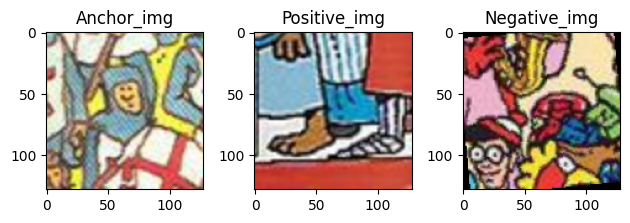

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have three tensors: image1, image2, image3
anchor_img, positive_img, negative_img, anchor_label = waldo_dataset.__getitem__(1309)

# Plotting the first image
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
plt.imshow(np.transpose(anchor_img, (1, 2, 0)))
plt.title('Anchor_img')

# Plotting the second image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
plt.imshow(np.transpose(positive_img, (1, 2, 0)))
plt.title('Positive_img')

# Plotting the third image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
plt.imshow(np.transpose(negative_img, (1, 2, 0)))
plt.title('Negative_img')

plt.tight_layout()  # To ensure proper spacing
plt.show()

# Split data into train-, validation- and testset

The used parameters are defined in the assignment

In [ ]:
train_ratio = 0.81
val_ratio = 0.09
test_ratio = 0.1

tolerance = 1e-10
#we add this tolerance because of rounding errors in floating point arithmetic
if not(abs(train_ratio + val_ratio + test_ratio - 1) < tolerance):
    raise Exception("invalid train/val/test ratios")

total_length = len(waldo_dataset.imgs)
train_boundary = int(train_ratio * total_length)
validation_boundary = int((train_ratio + val_ratio) * total_length)

#split in train test and val set
train_set = WaldoTripletDataset.create_subset_dataset(waldo_dataset, 0, train_boundary)
val_set = WaldoTripletDataset.create_subset_dataset(waldo_dataset, train_boundary, validation_boundary)
test_set = WaldoTripletDataset.create_subset_dataset(waldo_dataset, validation_boundary, total_length)

#disable train on test and val
test_set.is_train = False

#some checks
print(f'Total Set:\nlength: {len(waldo_dataset.imgs)}. \nTotal length: {total_length}. \npercentage: {round(len(waldo_dataset.imgs) / total_length * 100.0, 2) / 100}\nwaldos: {waldo_dataset.count_waldos()}\nwaldo percentage: {waldo_dataset.count_waldos() / len(waldo_dataset.imgs) * 100}\n')
print(f'TRAIN:\nlength: {len(train_set.imgs)}. \nTotal length: {total_length}. \npercentage: {round(len(train_set.imgs) / total_length * 100.0, 2) / 100}\nwaldos: {train_set.count_waldos()}\nwaldo percentage: {train_set.count_waldos() / len(train_set.imgs) * 100}\n')
print(f'VALIDATION:\nlength: {len(val_set.imgs)}. \nTotal length: {total_length}. \npercentage: {round(len(val_set.imgs) / total_length * 100.0, 2) / 100}\nwaldos: {val_set.count_waldos()}\nwaldo percentage: {val_set.count_waldos() / len(val_set.imgs) * 100}\n')
print(f'TEST:\nlength: {len(test_set.imgs)}. \nTotal length: {total_length}. \npercentage: {round(len(test_set.imgs) / total_length * 100.0, 2) / 100}\nwaldos: {test_set.count_waldos()}\nwaldo percentage: {test_set.count_waldos() / len(test_set.imgs) * 100}\n')


Total Set:
length: 6720. 
Total length: 6720. 
percentage: 1.0
waldos: 66
waldo percentage: 0.9821428571428571

TRAIN:
length: 5443. 
Total length: 6720. 
percentage: 0.81
waldos: 52
waldo percentage: 0.9553555024802498

VALIDATION:
length: 605. 
Total length: 6720. 
percentage: 0.09
waldos: 5
waldo percentage: 0.8264462809917356

TEST:
length: 672. 
Total length: 6720. 
percentage: 0.1
waldos: 9
waldo percentage: 1.3392857142857142



In [ ]:

#we duplicate every waldo n times.
duplicate_factor = 100
WaldoTripletDataset.duplicate_waldos(train_set, duplicate_factor)

print(f'{waldo_percentage(train_set)}%')

48.85706155743147%


In [ ]:
len(train_set.imgs)


5443

Define dataloaders

In [ ]:
#creating DataLoader for each dataset
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)

Model instantiation and testrun

In [ ]:
model = ViT(image_size = 128,
            patch_size = 16,
            num_classes = 2,
            dim = 512,
            num_layers = 3,
            heads = 8,
            dropout = 0.1).to(device)

random_input = torch.randn(1,3,128,128).to(device)
print(model(random_input).shape)

torch.Size([1, 2])


In [ ]:
epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
criterion = TripletLoss()

In [ ]:
print_every = 20
def train(epoch):
  model.train()
  train_loss = 0
  positive_dis = 0
  negative_dis = 0
  total = 0
  for batch_idx, (anchor_imgs, positive_imgs, negative_imgs, anchor_labels) in enumerate(train_loader):
    anchor_imgs = anchor_imgs.to(device)
    positive_imgs = positive_imgs.to(device)
    negative_imgs = negative_imgs.to(device)

    optimizer.zero_grad()
    anchor_out = model(anchor_imgs)
    positive_out = model(positive_imgs)
    negative_out = model(negative_imgs)

    loss, positive, negative = criterion(anchor_out, positive_out, negative_out)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    epoch_loss = train_loss/(batch_idx+1)

    positive_dis += positive.item()
    negative_dis += negative.item()

    if batch_idx % print_every == 0:
        print('Epoch {}/{}, Iter {}/{}, Train Loss: {:.3f}, positiv_dis: {:.3f}, negative_dis: {:.3f}'.format(epoch, epochs, batch_idx, len(train_loader), epoch_loss, positive_dis, negative_dis))
  return epoch_loss, positive_dis, negative_dis

In [ ]:
def validation():
  model.eval()
  val_loss = 0
  val_positive_dis = 0
  val_negative_dis = 0
  correct = 0
  total = 0
  with torch.no_grad():
      for batch_idx, (anchor_imgs, positive_imgs, negative_imgs, label) in enumerate(tqdm(val_loader)):
        anchor_imgs = anchor_imgs.to(device)
        positive_imgs = positive_imgs.to(device)
        negative_imgs = negative_imgs.to(device)

        optimizer.zero_grad()
        anchor_out = model(anchor_imgs)
        positive_out = model(positive_imgs)
        negative_out = model(negative_imgs)

        loss, positive, negative = criterion(anchor_out, positive_out, negative_out)


        val_loss += loss.item()
        val_positive_dis += positive.item()
        val_negative_dis += negative.item()

  loss = val_loss/(batch_idx+1)
  print('Val Loss: {:.3f}, positive distance: {:.3f}, negative distance: {:.3f}'.format(loss, positive, negative))
  return loss, val_positive_dis, val_negative_dis


In [ ]:
losses = []
pos_distance = []
neg_distance = []

val_losses = []
val_pos_distance = []
val_neg_distance = []
for epoch in range(epochs):
    epoch_loss, positive_dis, negative_dis = train(epoch)

    train_results = []
    labels = []
    model.eval()

    losses.append(epoch_loss)
    pos_distance.append(positive_dis)
    neg_distance.append(negative_dis)
    scheduler.step()

    val_loss, val_positive_dis, val_negative_dis = validation()
    val_losses.append(val_loss)
    val_pos_distance.append(val_positive_dis)
    val_neg_distance.append(val_negative_dis)

    state = {'model': model.state_dict(),
             'loss' : val_loss,
             'epoch': epoch}

    torch.save(state, f'model.pth_{epoch}')

Epoch 0/20, Iter 0/43, Train Loss: 1.001, positiv_dis: 0.004, negative_dis: 0.004
Epoch 0/20, Iter 20/43, Train Loss: 0.853, positiv_dis: 3.425, negative_dis: 13.462
Epoch 0/20, Iter 40/43, Train Loss: 0.566, positiv_dis: 11.631, negative_dis: 179.729


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Val Loss: 0.158, positive distance: 0.181, negative distance: 3.145
Epoch 1/20, Iter 0/43, Train Loss: 0.181, positiv_dis: 0.200, negative_dis: 2.824
Epoch 1/20, Iter 20/43, Train Loss: 0.113, positiv_dis: 4.136, negative_dis: 104.040
Epoch 1/20, Iter 40/43, Train Loss: 0.093, positiv_dis: 9.977, negative_dis: 253.243


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Val Loss: 0.037, positive distance: 0.322, negative distance: 10.036
Epoch 2/20, Iter 0/43, Train Loss: 0.035, positiv_dis: 0.420, negative_dis: 9.498
Epoch 2/20, Iter 20/43, Train Loss: 0.031, positiv_dis: 7.420, negative_dis: 254.765
Epoch 2/20, Iter 40/43, Train Loss: 0.042, positiv_dis: 13.588, negative_dis: 503.524


100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Val Loss: 0.032, positive distance: 0.227, negative distance: 8.555
Epoch 3/20, Iter 0/43, Train Loss: 0.041, positiv_dis: 0.211, negative_dis: 7.900
Epoch 3/20, Iter 20/43, Train Loss: 0.032, positiv_dis: 5.745, negative_dis: 180.320
Epoch 3/20, Iter 40/43, Train Loss: 0.033, positiv_dis: 8.574, negative_dis: 290.710


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Val Loss: 0.029, positive distance: 0.177, negative distance: 6.437
Epoch 4/20, Iter 0/43, Train Loss: 0.024, positiv_dis: 0.152, negative_dis: 5.868
Epoch 4/20, Iter 20/43, Train Loss: 0.025, positiv_dis: 5.278, negative_dis: 202.703
Epoch 4/20, Iter 40/43, Train Loss: 0.028, positiv_dis: 8.369, negative_dis: 330.906


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Val Loss: 0.042, positive distance: 0.268, negative distance: 11.939
Epoch 5/20, Iter 0/43, Train Loss: 0.018, positiv_dis: 0.236, negative_dis: 11.201
Epoch 5/20, Iter 20/43, Train Loss: 0.036, positiv_dis: 5.767, negative_dis: 192.759
Epoch 5/20, Iter 40/43, Train Loss: 0.034, positiv_dis: 9.905, negative_dis: 339.341


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Val Loss: 0.033, positive distance: 0.264, negative distance: 10.233
Epoch 6/20, Iter 0/43, Train Loss: 0.015, positiv_dis: 0.220, negative_dis: 9.878
Epoch 6/20, Iter 20/43, Train Loss: 0.027, positiv_dis: 5.499, negative_dis: 232.509
Epoch 6/20, Iter 40/43, Train Loss: 0.027, positiv_dis: 14.920, negative_dis: 527.814


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Val Loss: 0.028, positive distance: 0.252, negative distance: 12.384
Epoch 7/20, Iter 0/43, Train Loss: 0.018, positiv_dis: 0.220, negative_dis: 11.251
Epoch 7/20, Iter 20/43, Train Loss: 0.032, positiv_dis: 6.077, negative_dis: 175.073
Epoch 7/20, Iter 40/43, Train Loss: 0.032, positiv_dis: 9.735, negative_dis: 276.275


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Val Loss: 0.031, positive distance: 0.139, negative distance: 5.452
Epoch 8/20, Iter 0/43, Train Loss: 0.027, positiv_dis: 0.173, negative_dis: 4.994
Epoch 8/20, Iter 20/43, Train Loss: 0.030, positiv_dis: 4.088, negative_dis: 137.634
Epoch 8/20, Iter 40/43, Train Loss: 0.029, positiv_dis: 8.246, negative_dis: 292.132


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Val Loss: 0.012, positive distance: 0.200, negative distance: 8.105
Epoch 9/20, Iter 0/43, Train Loss: 0.023, positiv_dis: 0.229, negative_dis: 7.273
Epoch 9/20, Iter 20/43, Train Loss: 0.024, positiv_dis: 4.409, negative_dis: 160.719
Epoch 9/20, Iter 40/43, Train Loss: 0.024, positiv_dis: 9.648, negative_dis: 310.704


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Val Loss: 0.023, positive distance: 0.294, negative distance: 10.285
Epoch 10/20, Iter 0/43, Train Loss: 0.006, positiv_dis: 0.282, negative_dis: 9.730
Epoch 10/20, Iter 20/43, Train Loss: 0.026, positiv_dis: 6.382, negative_dis: 214.650
Epoch 10/20, Iter 40/43, Train Loss: 0.028, positiv_dis: 9.165, negative_dis: 311.969


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Val Loss: 0.012, positive distance: 0.177, negative distance: 5.605
Epoch 11/20, Iter 0/43, Train Loss: 0.044, positiv_dis: 0.153, negative_dis: 4.917
Epoch 11/20, Iter 20/43, Train Loss: 0.031, positiv_dis: 4.137, negative_dis: 118.779
Epoch 11/20, Iter 40/43, Train Loss: 0.030, positiv_dis: 8.101, negative_dis: 244.140


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Val Loss: 0.026, positive distance: 0.196, negative distance: 9.192
Epoch 12/20, Iter 0/43, Train Loss: 0.028, positiv_dis: 0.256, negative_dis: 8.207
Epoch 12/20, Iter 20/43, Train Loss: 0.033, positiv_dis: 4.521, negative_dis: 170.882
Epoch 12/20, Iter 40/43, Train Loss: 0.029, positiv_dis: 7.370, negative_dis: 275.579


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Val Loss: 0.038, positive distance: 0.218, negative distance: 7.776
Epoch 13/20, Iter 0/43, Train Loss: 0.016, positiv_dis: 0.177, negative_dis: 6.992
Epoch 13/20, Iter 20/43, Train Loss: 0.033, positiv_dis: 3.804, negative_dis: 133.310
Epoch 13/20, Iter 40/43, Train Loss: 0.031, positiv_dis: 6.715, negative_dis: 235.620


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Val Loss: 0.023, positive distance: 0.159, negative distance: 5.129
Epoch 14/20, Iter 0/43, Train Loss: 0.025, positiv_dis: 0.131, negative_dis: 4.844
Epoch 14/20, Iter 20/43, Train Loss: 0.021, positiv_dis: 3.405, negative_dis: 120.691
Epoch 14/20, Iter 40/43, Train Loss: 0.025, positiv_dis: 7.311, negative_dis: 262.669


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Val Loss: 0.033, positive distance: 0.181, negative distance: 7.473
Epoch 15/20, Iter 0/43, Train Loss: 0.005, positiv_dis: 0.171, negative_dis: 6.804
Epoch 15/20, Iter 20/43, Train Loss: 0.022, positiv_dis: 4.484, negative_dis: 159.697
Epoch 15/20, Iter 40/43, Train Loss: 0.021, positiv_dis: 9.228, negative_dis: 318.027


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Val Loss: 0.058, positive distance: 0.236, negative distance: 9.935
Epoch 16/20, Iter 0/43, Train Loss: 0.037, positiv_dis: 0.272, negative_dis: 8.986
Epoch 16/20, Iter 20/43, Train Loss: 0.029, positiv_dis: 4.732, negative_dis: 166.737
Epoch 16/20, Iter 40/43, Train Loss: 0.027, positiv_dis: 8.568, negative_dis: 294.319


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Val Loss: 0.025, positive distance: 0.206, negative distance: 6.572
Epoch 17/20, Iter 0/43, Train Loss: 0.008, positiv_dis: 0.203, negative_dis: 6.308
Epoch 17/20, Iter 20/43, Train Loss: 0.025, positiv_dis: 4.247, negative_dis: 130.484
Epoch 17/20, Iter 40/43, Train Loss: 0.023, positiv_dis: 8.404, negative_dis: 253.682


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Val Loss: 0.044, positive distance: 0.200, negative distance: 7.055
Epoch 18/20, Iter 0/43, Train Loss: 0.019, positiv_dis: 0.197, negative_dis: 6.741
Epoch 18/20, Iter 20/43, Train Loss: 0.027, positiv_dis: 4.402, negative_dis: 138.334
Epoch 18/20, Iter 40/43, Train Loss: 0.024, positiv_dis: 8.497, negative_dis: 264.257


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Val Loss: 0.023, positive distance: 0.197, negative distance: 6.874
Epoch 19/20, Iter 0/43, Train Loss: 0.016, positiv_dis: 0.167, negative_dis: 6.279
Epoch 19/20, Iter 20/43, Train Loss: 0.020, positiv_dis: 4.295, negative_dis: 133.787
Epoch 19/20, Iter 40/43, Train Loss: 0.021, positiv_dis: 8.371, negative_dis: 260.393


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]

Val Loss: 0.023, positive distance: 0.238, negative distance: 6.582


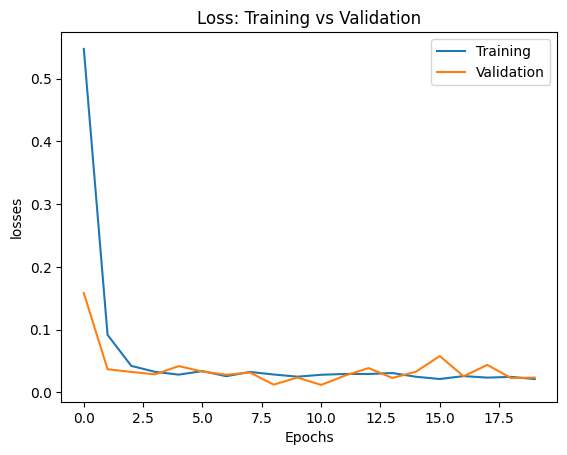

In [ ]:
# Plotting the data
plt.plot(losses, label='Training')
plt.plot(val_losses, label='Validation')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('losses')
plt.title('Loss: Training vs Validation')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

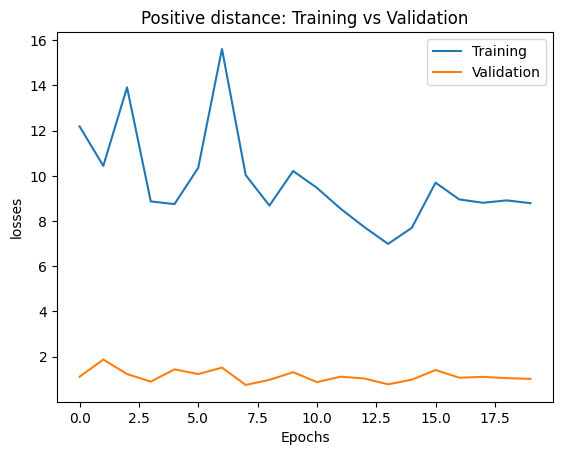

In [ ]:
# Plotting the data
plt.plot(pos_distance, label='Training')
plt.plot(val_pos_distance, label='Validation')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('losses')
plt.title('Positive distance: Training vs Validation')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

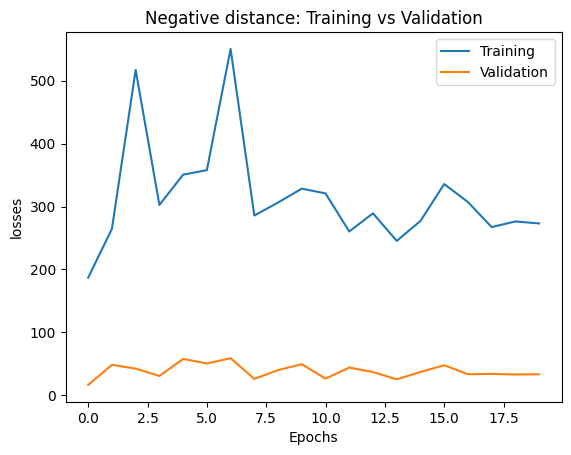

In [ ]:
# Plotting the data
plt.plot(neg_distance, label='Training')
plt.plot(val_neg_distance, label='Validation')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('losses')
plt.title('Negative distance: Training vs Validation')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

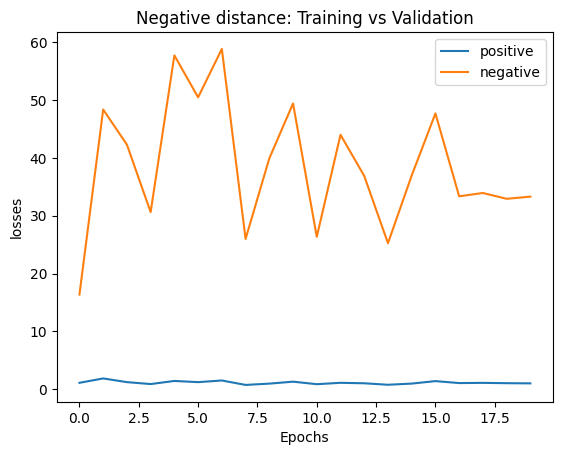

In [ ]:
# Plotting the data
plt.plot(val_pos_distance, label='positive')
plt.plot(val_neg_distance, label='negative')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('losses')
plt.title('Negative distance: Training vs Validation')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
model = ViT(image_size = 128,
            patch_size = 16,
            num_classes = 2,
            dim = 512,
            num_layers = 3,
            heads = 8,
            dropout = 0.1).to(device)
checkpoint = torch.load('/content/model.pth_12') #chose your figther
model.load_state_dict(checkpoint['model'])
model.eval()

In [ ]:
train_results = []
labels = []
model.eval()
with torch.no_grad():
    for img, _, _, label in tqdm(test_loader):
        train_results.append(model(img.to(device)).cpu().numpy())
        labels.append(label)

train_results = np.concatenate(train_results)
labels = np.concatenate(labels)
train_results.shape

In [ ]:
plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)
plt.legend()
plt.show()